In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import numpy as np
import nibabel as nib

import torch
import torch.nn as nn
import torch.utils.data
import torchvision

from scipy.ndimage import zoom

import matplotlib.pyplot as plt
from torchvision.utils import make_grid


In [59]:
import sys

from multiprocessing import Process, Queue
from time import time, sleep

sys.path.insert(1, 'scripts')
from integral_volume import (Point3d, IntegralVol, IntegralVolTest)
from niblack3d import Niblack3d
from multyprocess_utils import MultuProcMain

In [60]:
IntegralVolTest()

preprocess time 0.16104388236999512
numpy time 0.4661881923675537
integral vol time 0.00013136863708496094
calculation error 1.2703821994364261e-09


In [61]:
brain_file = nib.load("data/sub-299_ses-20110422_desc-angio_N4bfc_brain_mask.nii.gz")

brain_vol = np.array(brain_file.dataobj)

print(brain_vol.shape)
print(brain_vol.mean())
print(brain_vol.sum())

##compressed
#brain_vol = zoom(brain_vol, (0.25, 0.25, 0.25))
#print(brain_vol.shape)
#print(brain_vol.mean())
#print(brain_vol.sum())

(512, 512, 140)
56.166653
2061325200.0


In [62]:
new_vol = np.zeros((512, 512, 164))
new_vol[:, :, 12:152] = brain_vol
brain_vol = new_vol

In [77]:
def print_img(vol, axis, title= 'title', slice=None, cmap='hot'):
    global SHOW_SLICE
    #axis.set_xticks([])
    #axis.set_yticks([])
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, slice], cmap=cmap)
    plt.colorbar(im)

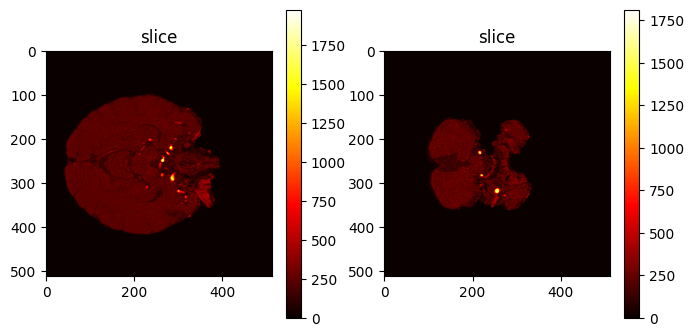

In [64]:
SHOW_SLICE = 31

fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
print_img(brain_vol, ax[0], 'slice', 100)    
print_img(brain_vol, ax[1], 'slice')  

In [65]:
img_hist = np.histogram(brain_vol, bins=100, range=(brain_vol.min(), brain_vol.max()))

1

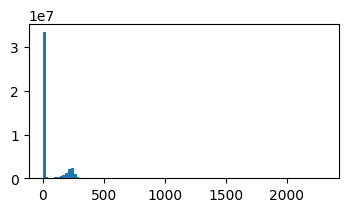

In [66]:
counts, bins = img_hist

plt.subplots(figsize=(4, 2)) 
plt.hist(bins[:-1], bins, weights=counts, range=(0, 500))
1

1

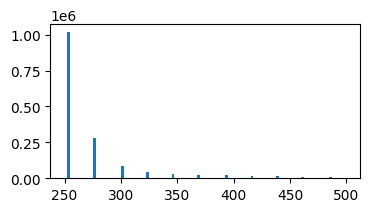

In [67]:
plt.subplots(figsize=(4, 2))    
plt.hist(bins[:-1], 100, weights=counts, range=(250, 500))
1

In [68]:
test_vol = brain_vol
print(test_vol.shape)

(512, 512, 164)


In [88]:
window_size = (25, 25, 9)
coef_k = 0.5
coef_a = 100

In [89]:
start = time()
bin_vol = MultuProcMain(test_vol, window_size=window_size, coef_k=coef_k, coef_a=coef_a)
print("spend:", time() - start)

spend: 62.718841314315796


[autoreload of niblack3d failed: Traceback (most recent call last):
  File "/home/msst/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/msst/.local/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 844, in exec_module
  File "<frozen importlib._bootstrap_external>", line 981, in get_code
  File "<frozen importlib._bootstrap_external>", line 911, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/msst/repo/VesselSegmentation/scripts/niblack3d.py", line 69
    def __init__(self, window_size=(3, 3, 3), threshold):
                 ^
SyntaxError: non-def

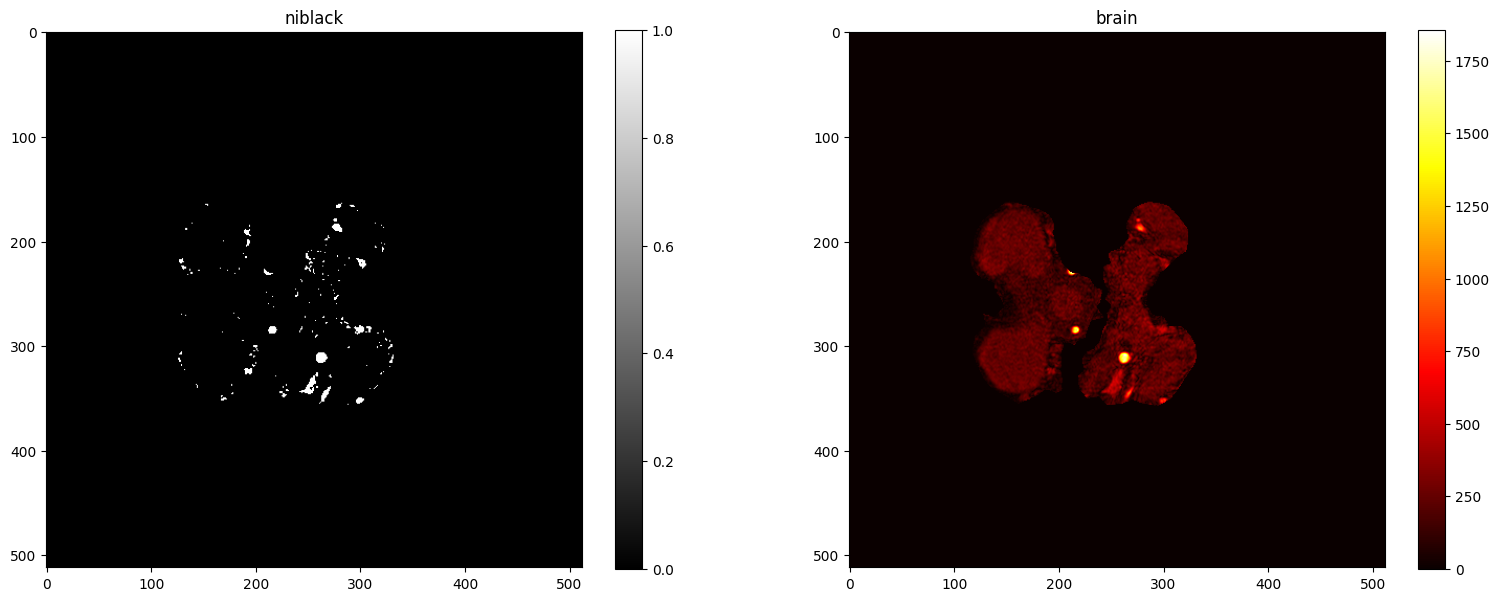

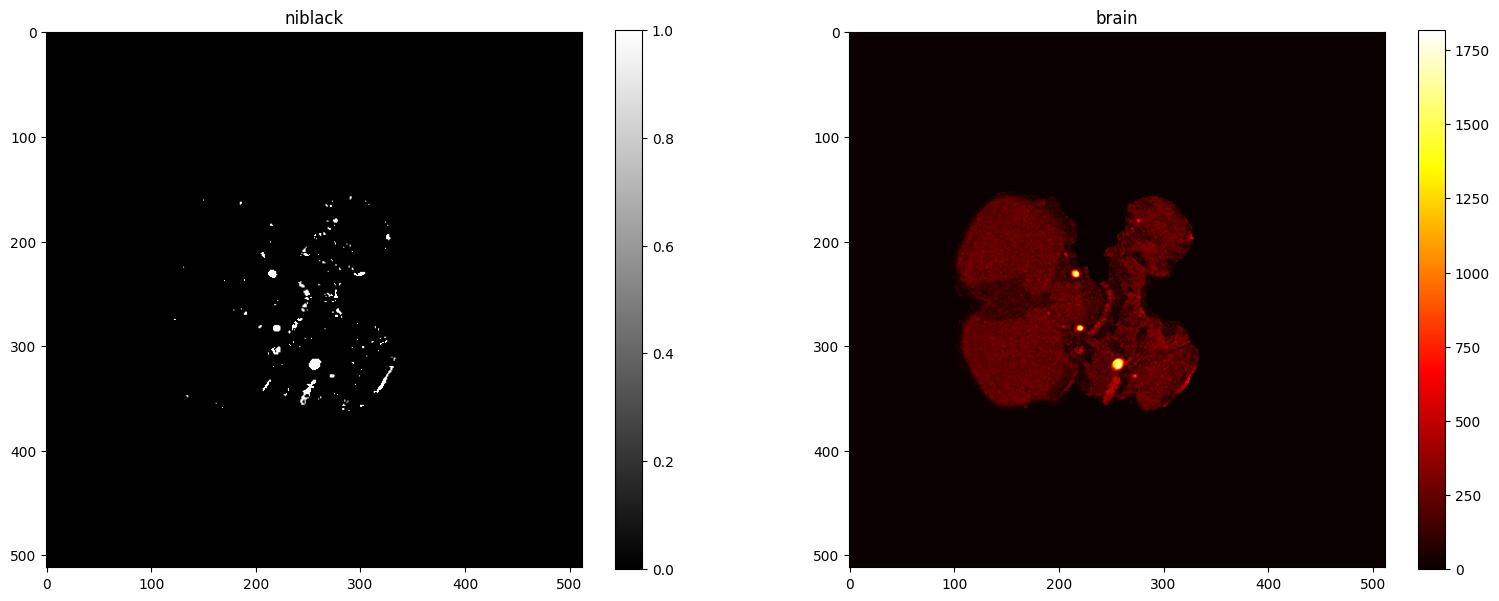

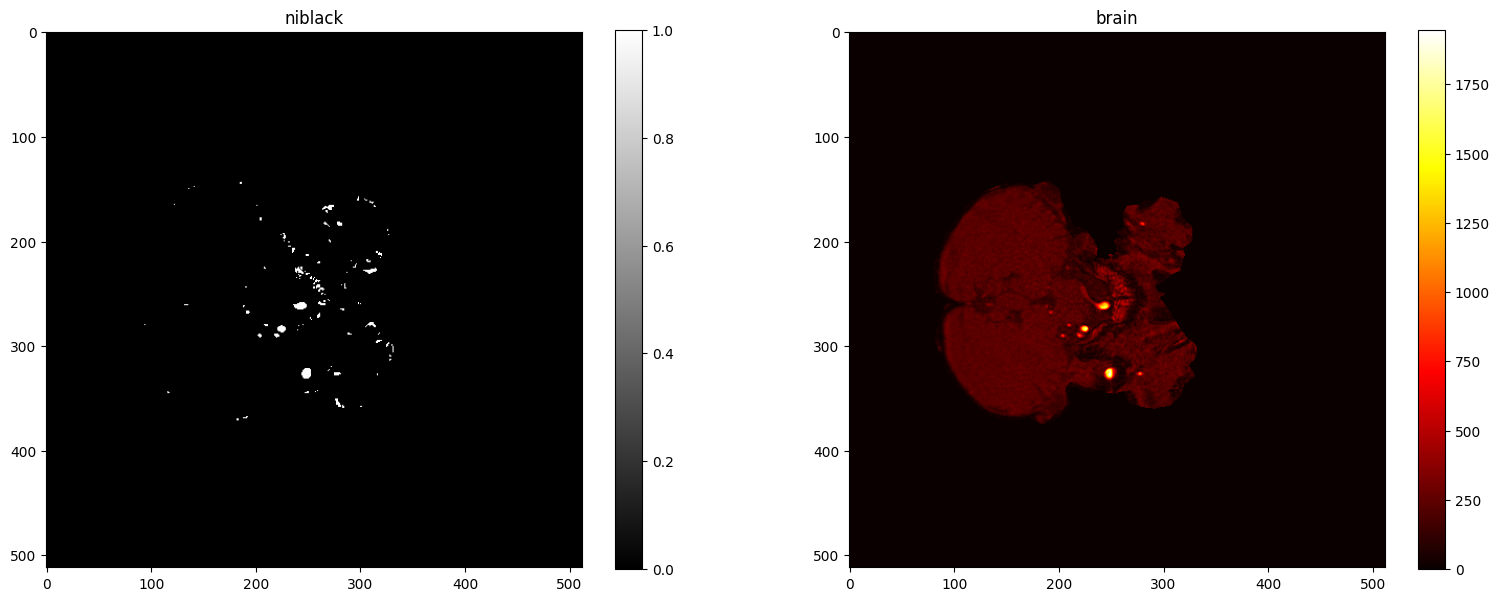

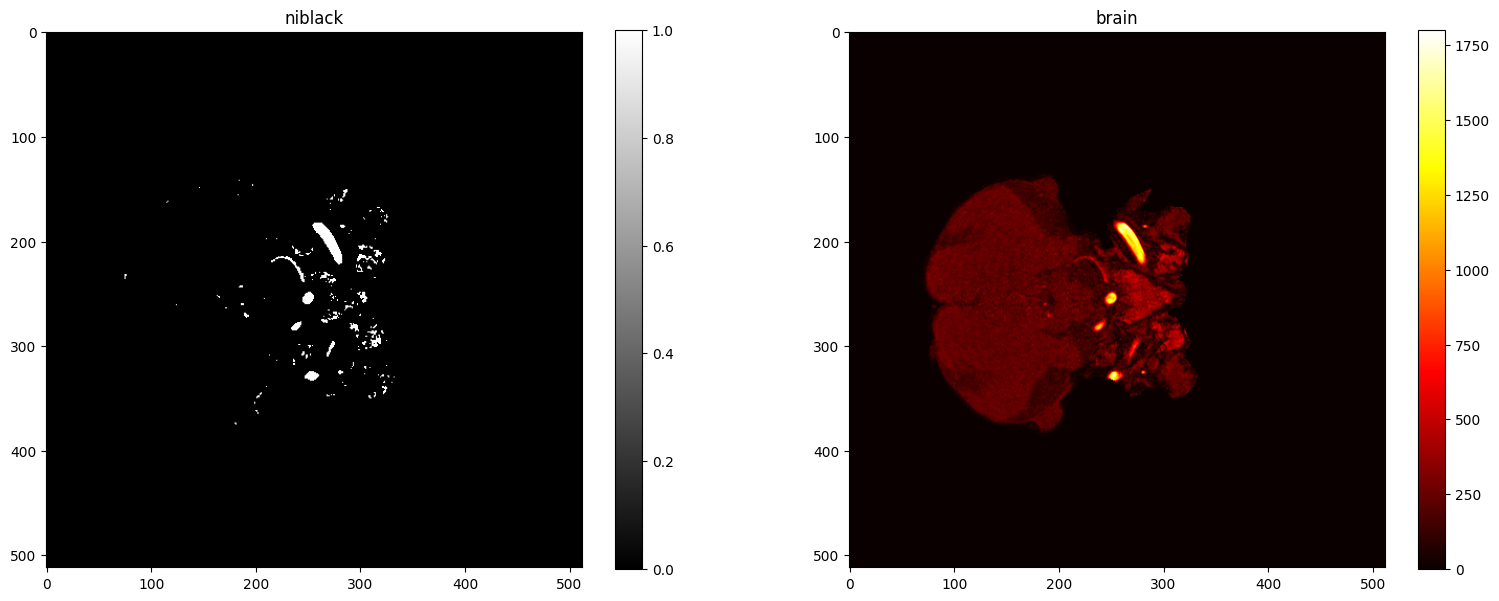

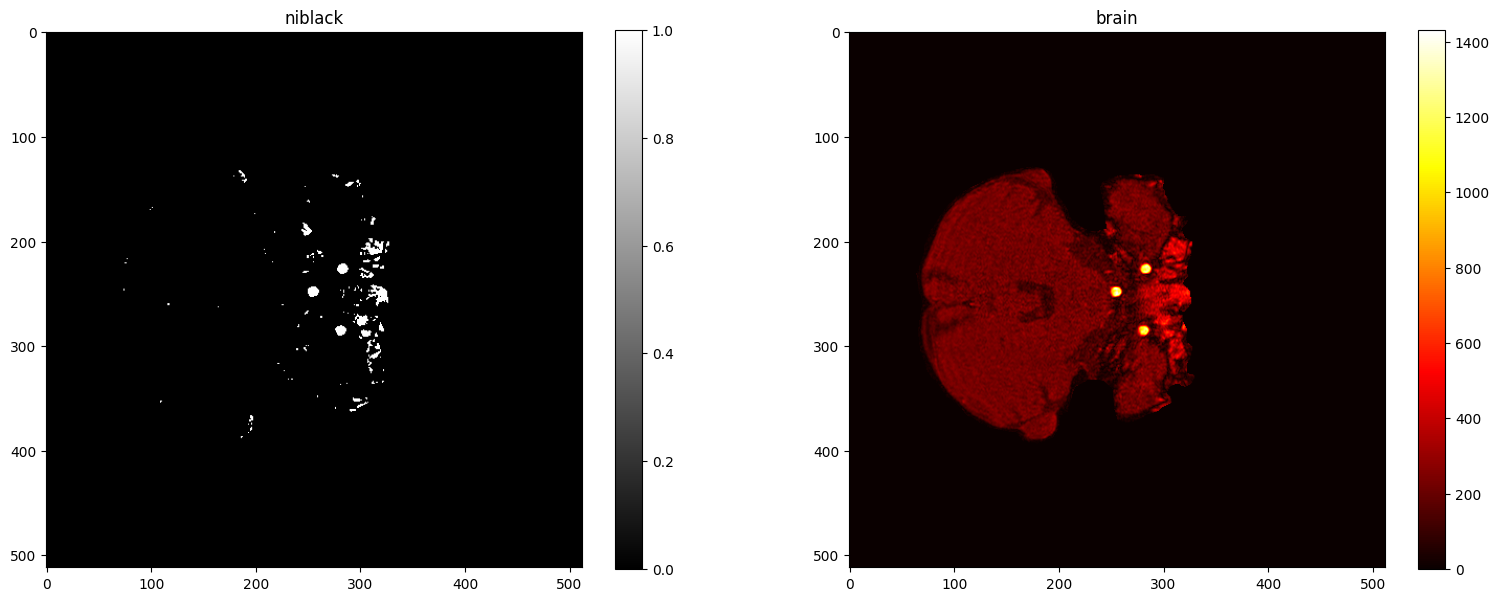

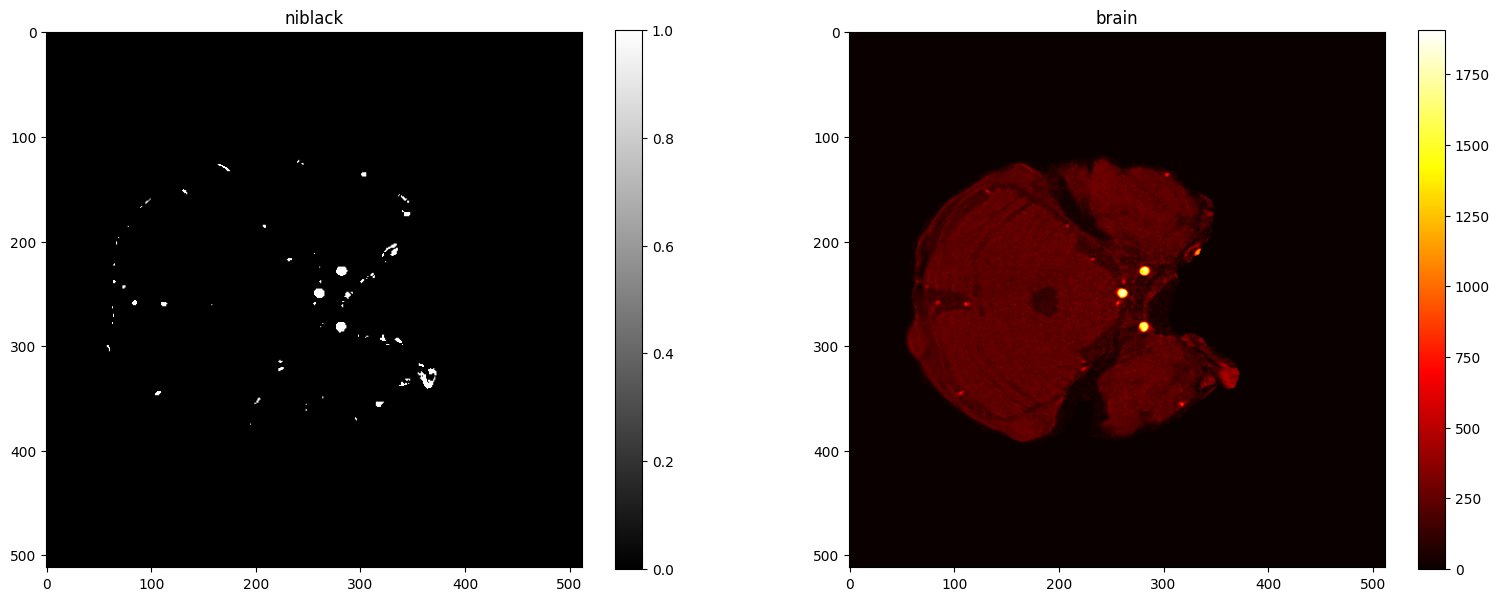

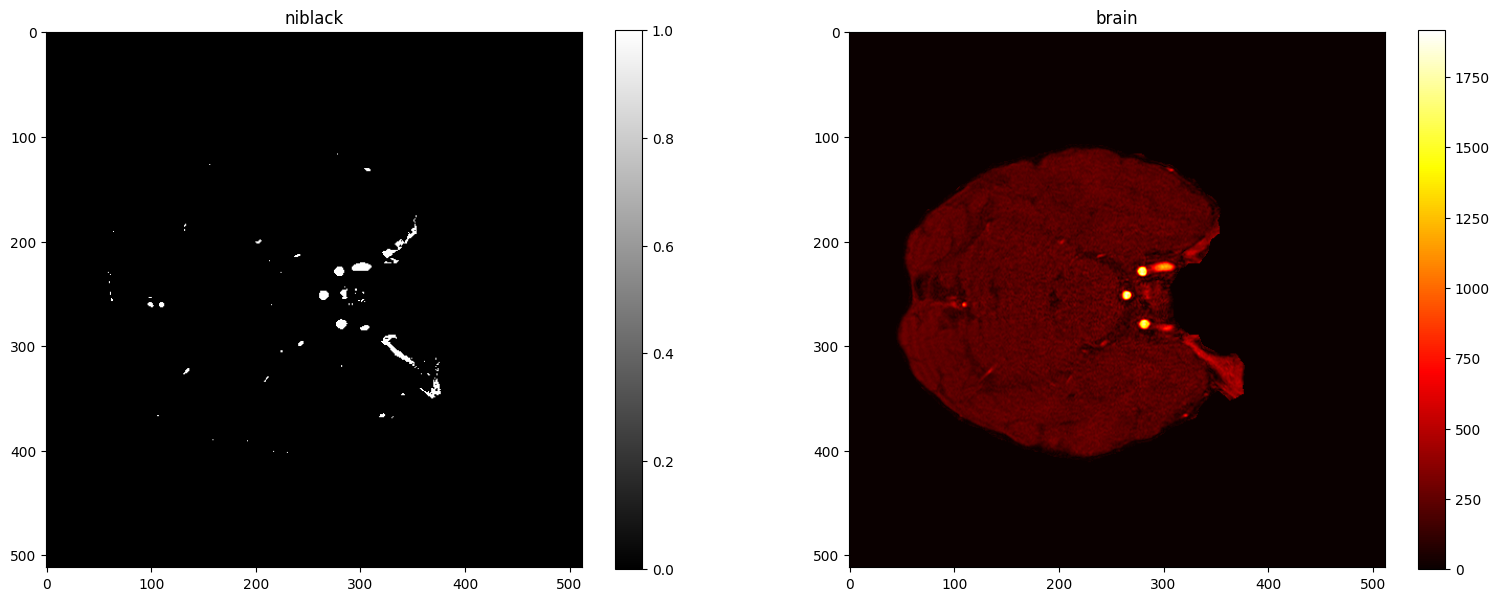

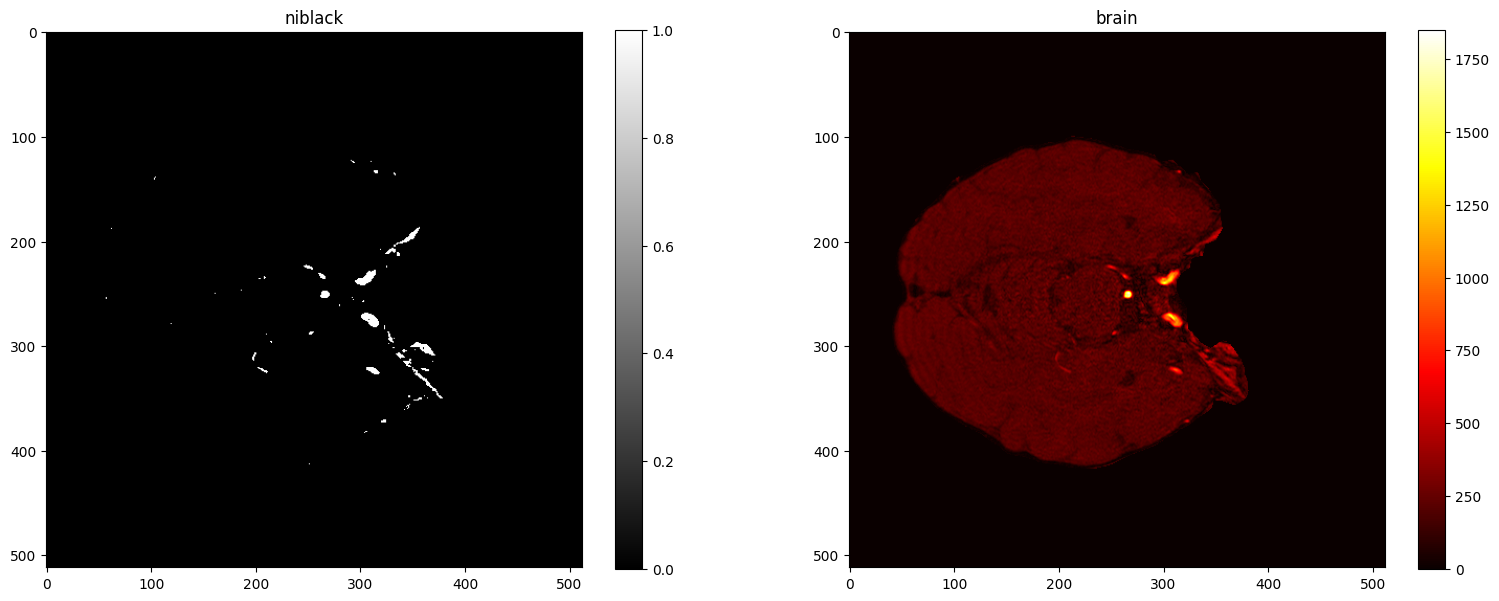

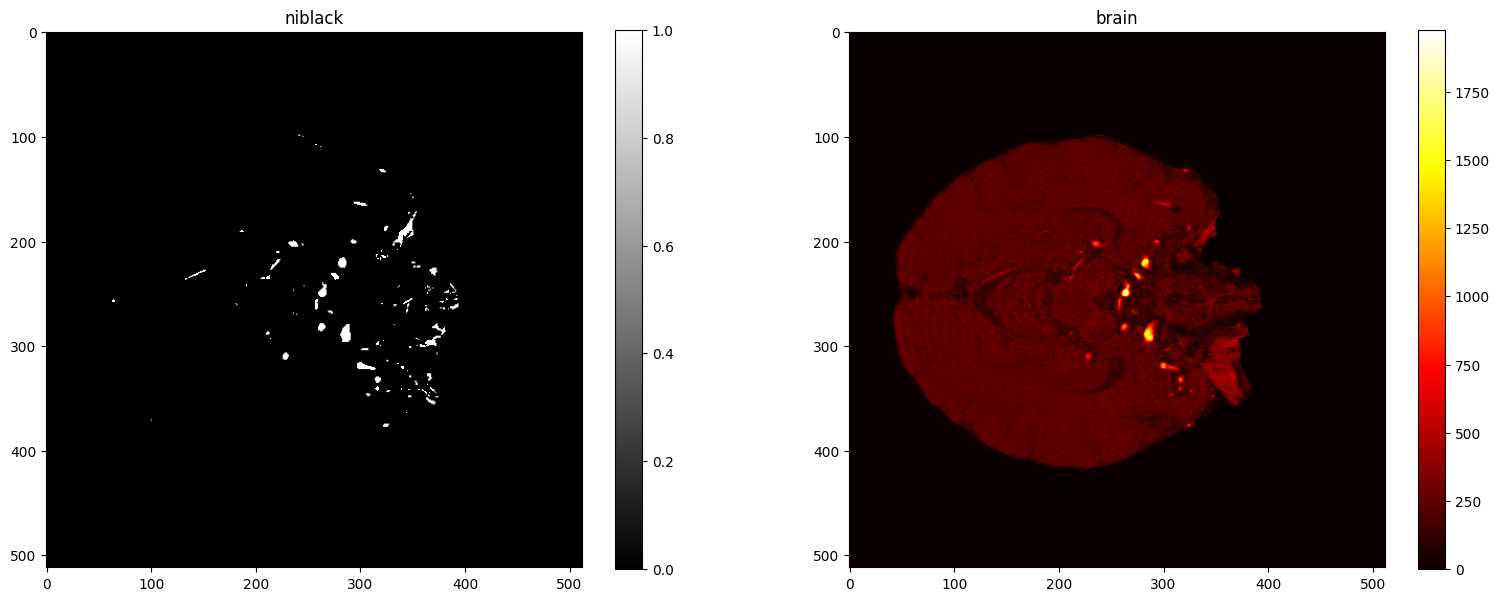

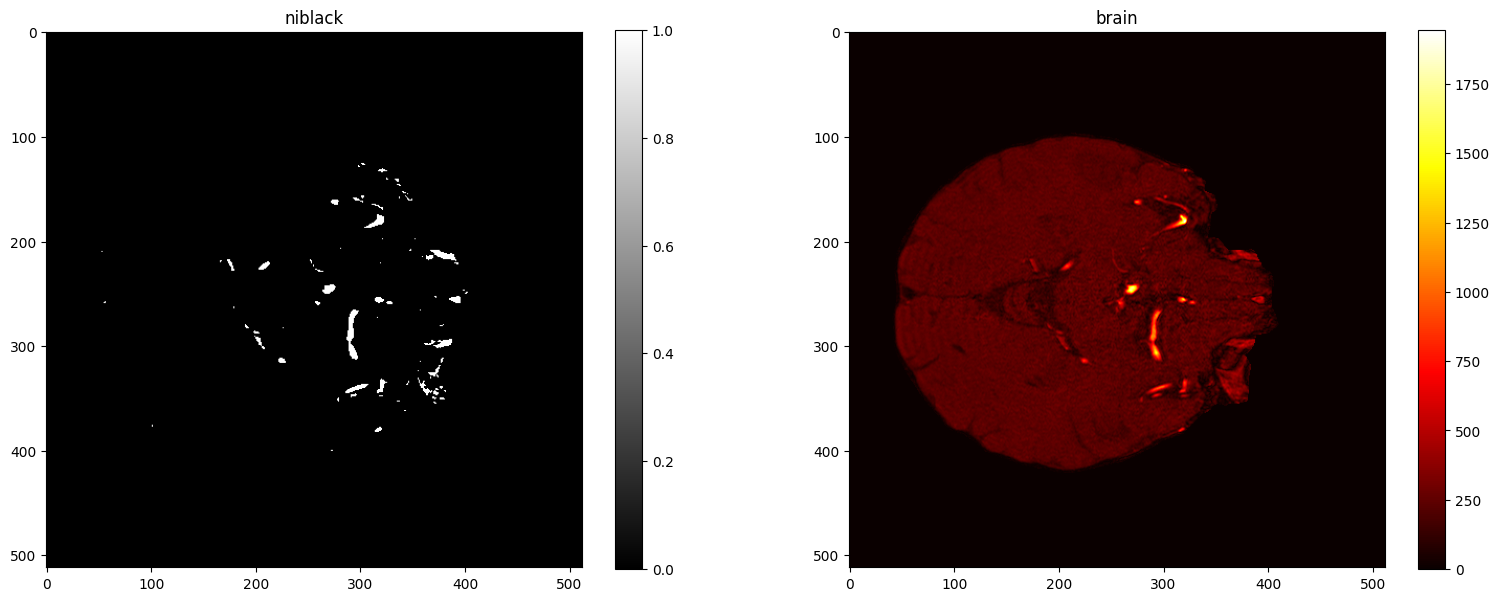

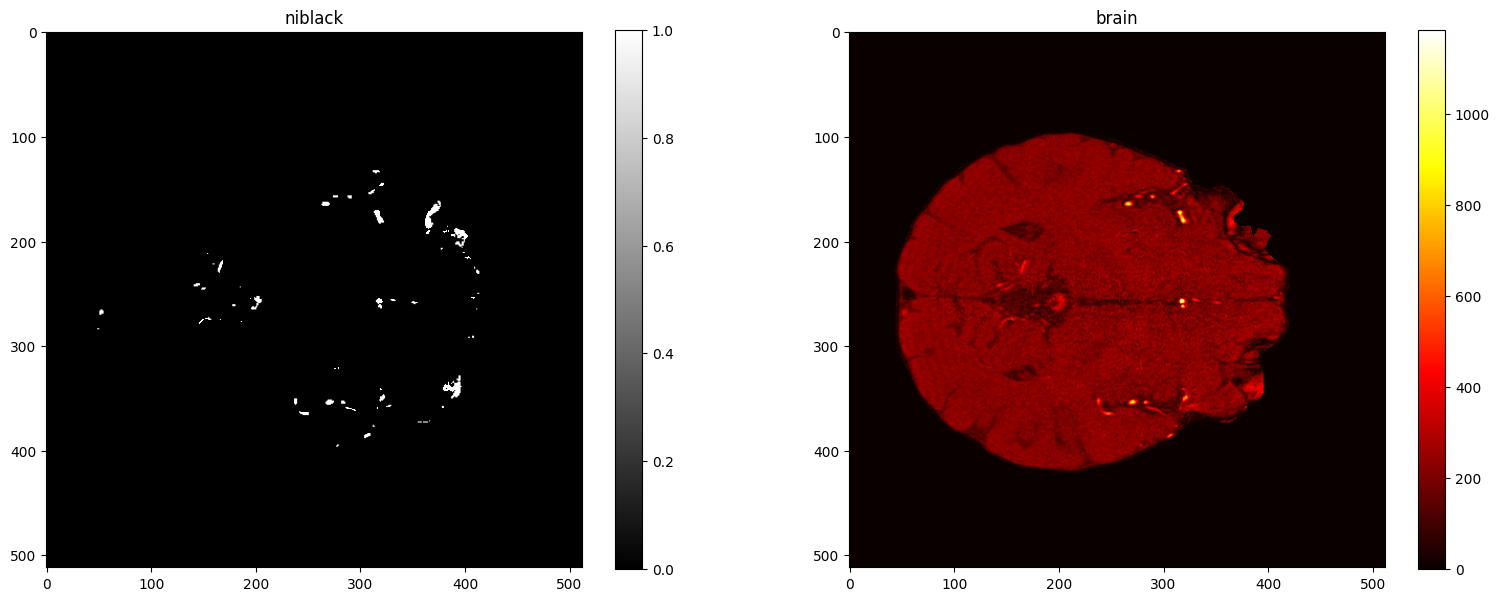

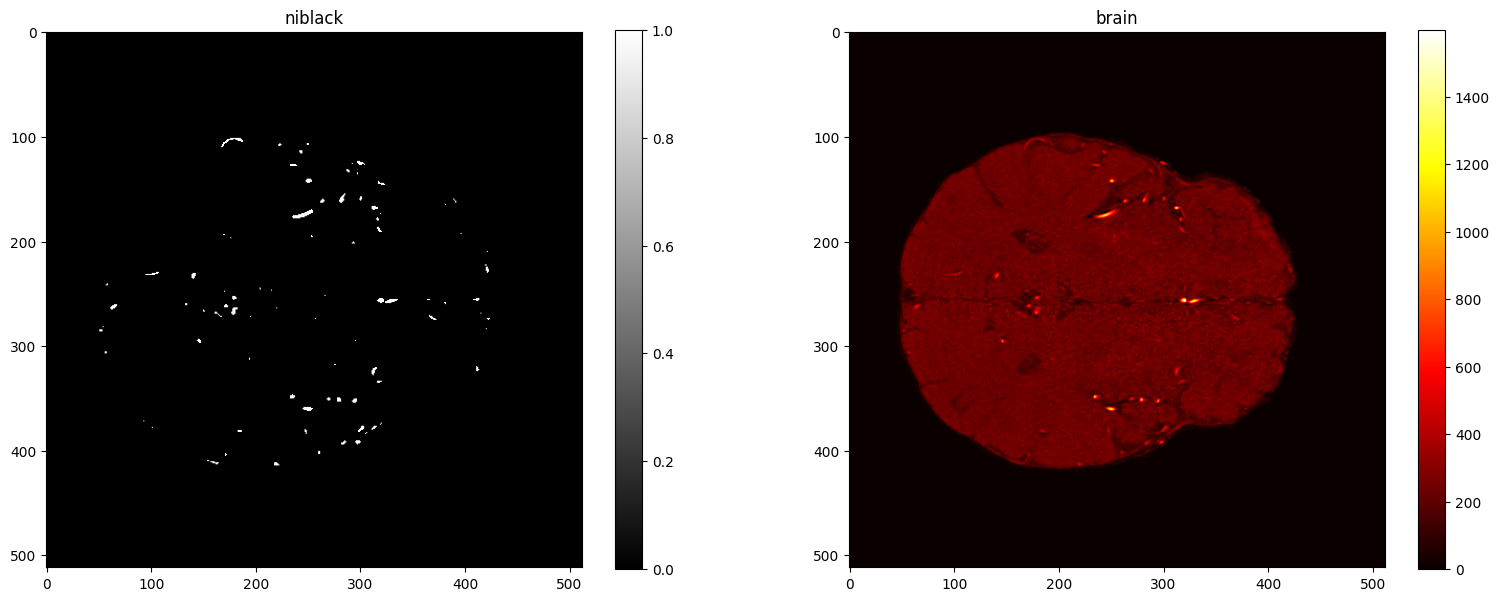

In [91]:
for idx in range(20, 140, 10):    
    SHOW_SLICE = idx

    fig, ax = plt.subplots(1, 2, figsize=(19, 7))    
    print_img(bin_vol, ax[0], 'niblack', cmap='gray')    
    print_img(test_vol, ax[1], 'brain')  

In [57]:
#sigmas = np.array(sigmas)
#sigmas_hist = np.histogram(sigmas, bins=100, range=(sigmas.min(), sigmas.max()))

#counts, bins = sigmas_hist

#plt.subplots(figsize=(4, 2)) 
#plt.hist(bins[1:-1], bins[1:], weights=counts[1:])

In [54]:
def save_vol_as_nii(numpy_arr, loaded_file, path_to_save):
    empty_header = nib.Nifti1Header()
    Nifti1Image = nib.Nifti1Image(numpy_arr, loaded_file.affine, empty_header)
    nib.save(Nifti1Image, path_to_save)

In [55]:
path_to_save_brain = 'seg_data/brain_vol_compressed1.nii.gz'
path_to_save_seg = 'seg_data/seg_vol_compressed1.nii.gz'

save_vol_as_nii(test_vol, brain_file, path_to_save_brain)
save_vol_as_nii(bin_vol, brain_file, path_to_save_seg)

In [112]:
def calc_mu(integr_vol, window_size, p1, p2):
    mu = integr_vol.calculate_sum(p1, p2)
    mu *= (1/window_size[0]/window_size[1]/window_size[2])
    return mu
    
def calc_T(integr, integr_sq, w_s, f, s):

    mu = calc_mu(integr, window_size, f, s)
    mu_sq = calc_mu(integr_sq, window_size, f, s)

    sigma = mu_sq - mu**2
    eps = 1e-6
    sigma += eps

    if sigma<0:
        print(i, j, k, ": sigma<0")
        sigma = 0
    #assert sigma >= 0

    sigma = sigma**0.5
    T = mu + (coef_k * sigma) + coef_a
    return(T, sigma)

def niblack3d(vol, window_size=(3, 3, 3), coef_k=0, coef_a=0): 
    bin_vol = np.zeros_like(vol, dtype=bool)

    sigmas = []
    
    for i in range(0, integr.integral_vol.shape[0]-1):
        for j in range(0, integr.integral_vol.shape[1]-1):
            for k in range(0, integr.integral_vol.shape[2]-1):

                w_s = (window_size[0]//2, window_size[1]//2, window_size[2]//2)
                
                f = Point3d(i-w_s[0], j-w_s[1], k-w_s[2]).edit_to_vol(bin_vol)
                s = Point3d(i+w_s[0], j+w_s[1], k+w_s[2]).edit_to_vol(bin_vol)
                
                T, sigma = calc_T(integr, integr_sq, w_s, f, s)
                
                sigmas.append(sigma)
                
                if vol[i, j, k]>=T:
                    bin_vol[i, j, k] = 1  
                    
    return(bin_vol, sigmas)

In [113]:
window_size = (11, 11, 5)
coef_k = 0.2
coef_a = 125
bin_vol, sigmas = niblack3d(test_vol, window_size=window_size, coef_k=coef_k, coef_a=coef_a)

1

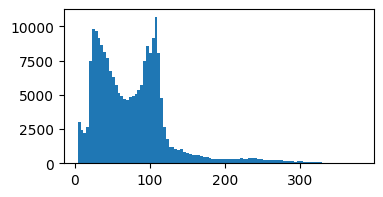

In [117]:
sigmas = np.array(sigmas)
sigmas_hist = np.histogram(sigmas, bins=100, range=(sigmas.min(), sigmas.max()))

counts, bins = sigmas_hist

plt.subplots(figsize=(4, 2)) 
plt.hist(bins[1:-1], bins[1:], weights=counts[1:])
1

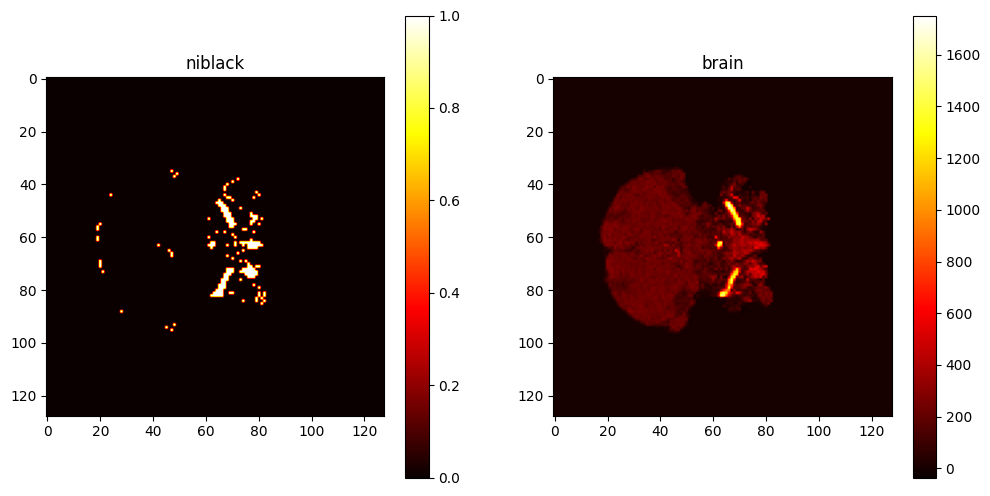

In [111]:
SHOW_SLICE = 10

fig, ax = plt.subplots(1, 2, figsize=(12, 6))    
print_img(bin_vol, ax[0], 'niblack')    
print_img(test_vol, ax[1], 'brain')  